In [27]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
import warnings
from IPython import get_ipython

warnings.filterwarnings('ignore', category=DeprecationWarning)

## Data Preparation

In [3]:
from data.clean import clean
from utils.tokenize import tokenize_data

In [22]:
# Generate clean data
tweet_dta = clean('data/text_dta.csv')
tweet_dta.loc[:,'date'] = pd.to_datetime(tweet_dta.loc[:,'date'])
# Text tokenization
tweet_dict_lst = tokenize_data(tweet_dta)

In [24]:
tweet_dta.head(5)

,date,tweet,related_news
0,2011-07-15,回复@曹豫生:高要求是必须的，无论对媒体还是高铁~~ //@曹豫生:高铁要真正做好，媒体要真...,因高铁故障而滞留的乘客们，因为受到的糟糕服务而抱怨是非常正常的，借此大肆炒作的媒体是不够正常...
1,2011-07-15,岭南大学文化研究系，香港思想领域的少数派、坚持者。这篇文章对于思考宗教、保守主义运动都有参考价值。,罗永生：作为保守主义社会运动的宗教右派 网页链接 宗教右派是一种新保守主义的政治运动和...
2,2011-07-16,赞右边，在今天的中国，具体思考比抽象搬用概念可贵。//@罗马拾荒人：大好还是小好，就像人的器...,【汪洋：巩固大部制改革须建“小政府”“大社会”】实行大部制必须建设“小政府”，建设“小政府”...
3,2011-07-17,观察者觉得，这是个伪问题。爱不爱如此打扮，随便。遭到强奸，请警察依法处理。再说，如此打扮的妇...,7月16日，一些示威者在韩国首尔街头游行。当日，部分韩国市民在首尔举行“荡妇游行”示威活动。...
4,2011-07-17,玩微博事小，爱护电脑事大。根据观察者的观察，笔记本进水后即使暂时没事，也不可掉以轻心。应关闭...,[表扬]：中午的时候我媳妇一不小心把一杯水全部泼到了我的联想（thinkpad）笔记本上，结...


In [26]:
print(tweet_dict_lst[0])

{'date': Timestamp('2011-07-15 00:00:00'), 'tweet': '回复@曹豫生:高要求是必须的，无论对媒体还是高铁~~ //@曹豫生:高铁要真正做好，媒体要真正自重，这要求是不是太高了？', 'news': '因高铁故障而滞留的乘客们，因为受到的糟糕服务而抱怨是非常正常的，借此大肆炒作的媒体是不够正常的。其实乘客们心里都会祝愿祖国强盛。希望高铁不仅提升中国实力，也提升铁道部服务水平，尽力照顾好不分贵贱的所有热爱高铁的乘客。 ', 'tokens': ['回复', '曹豫生', '媒体', '高铁', '曹豫生', '高铁', '做好', '媒体', '自重', '太高', '高铁', '故障', '滞留', '乘客', '糟糕', '服务', '抱怨', '借此', '大肆', '炒作', '媒体', '乘客', '祝愿', '祖国', '强盛', '希望', '高铁', '提升', '中国', '实力', '提升', '铁道部', '服务水平', '尽力', '照顾', '不分', '贵贱', '热爱', '高铁', '乘客']}


## Topic Modeling

**Latent Dirichlet Allocation (LDA) Algorithm** is used as a topic modelling technique that can classify text in a document to a particular topic. It uses Dirichlet distribution to find topics for each document model and words for each topic model.

https://medium.com/analytics-vidhya/latent-dirichelt-allocation-1ec8729589d4

### Model Construction

In [29]:
def decide_num_topics(text_dta, corpus, dictionary, coherence=False, perplexity=False):
    """
    Calculate coherence score for different num of topics
    
    Inputs:
        text_dta: a list of lists of tokens
        corpus: a list of lists where each list contains tuples 
            mapping each token's id with its frequency
        dictionary: a gensim.corpora.Dictionary object
        coherence & perplxity(boolean): calculate relevant scores
            when the specified value is True
    Outputs:
        scores_dict: a dict where key is the number of topics and the
            value is the score
    """
    
    num_topics_range = range(2, 21)
    scores_dict = dict()
    
    if coherence:
        for num in num_topics_range:
            lda_model = LdaModel(corpus, 
                                 num_topics=num, 
                                 id2word=dictionary, 
                                 random_state=42)
            coherence_model = CoherenceModel(model=lda_model, 
                                             texts=text_dta, 
                                             dictionary=dictionary, 
                                             coherence='c_v')
            scores_dict[num] = coherence_model.get_coherence()
    
    if perplexity:
        for num in num_topics_range:
            lda_model = LdaModel(corpus, 
                                 num_topics=num, 
                                 id2word=dictionary, 
                                 random_state=42)
            scores_dict[num] = lda_model.log_perplexity(corpus)
    
    return scores_dict


def gene_plot(coherence_dict, perplexity_dict):
    """
    Plot the coherence and perplexity scores against the num of topics
    
    Inputs:
        coherence_dict, perplexity_dict: a dict where key is the number 
        of topics and the value is the score
    """
    
    fig, ax1 = plt.subplots()
    num_topics_range = coherence_dict.keys()
    coherence_scores, perplexities = coherence_dict.values(), perplexity_dict.values()

    # Plot coherence scores on the primary y-axis (left)
    ax1.plot(num_topics_range, coherence_scores, 'b-o', label='Coherence Score')
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Coherence Score')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend(loc='upper left')

    # Create a secondary y-axis (right) for perplexities
    ax2 = ax1.twinx()
    ax2.plot(num_topics_range, perplexities, 'g-o', label='Perplexity')
    ax2.set_ylabel('Perplexity')
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.legend(loc='upper right')

    plt.title('LDA Coherence Score and Perplexity vs. Number of Topics')
    plt.grid()
    plt.show()

#### Corpus Setup

In [30]:
# Attain a list of lists of tokens
token_documents = []
for tweet_dict in tweet_dict_lst:
    token_documents.append(tweet_dict['tokens'])

# Create a Dictionary encapsulates the mapping between normalized 
# words and their integer ids
dictionary = corpora.Dictionary(token_documents)
    
# Convert document (a list of words) into the bag-of-words format
# i.e. list of (token_id, token_count)
bag_of_tokens = [dictionary.doc2bow(doc) for doc in token_documents]

#### Topic Number Selection Based on Perplexity and Coherence Score

In [ ]:
# Decide the optimal num of topics
coherence_dict = decide_num_topics(token_documents, bag_of_tokens, dictionary, coherence=True)
perplexity_dict = decide_num_topics(token_documents, bag_of_tokens, dictionary, perplexity=True)

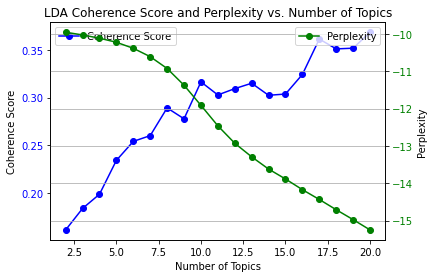

In [20]:
gene_plot(coherence_dict, perplexity_dict)

#### Generate the LDA Model and Visualize the Result

In [8]:
import pickle

In [9]:
# Play around the num of topics and train the LDA model
num_topics = 9
lda_model = LdaModel(bag_of_tokens, num_topics=num_topics, id2word=dictionary, random_state=42)

In [10]:
# Visualization of topic Selection
vis_data = gensimvis.prepare(lda_model, bag_of_tokens, dictionary)

# Save the vis_data object to a file
with open('data/vis_data.pkl', 'wb') as f:
    pickle.dump(vis_data, f)

In [11]:
with open('data/vis_data.pkl', 'rb') as f:
    vis_data = pickle.load(f)
    
pyLDAvis.display(vis_data)

## Result Analysis - Example

### Trend Analysis

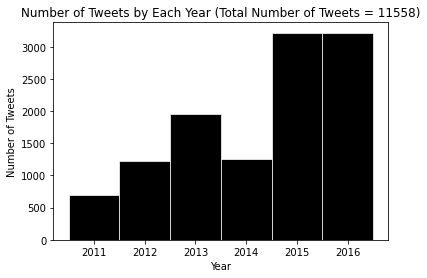

In [47]:
# Number of Tweets by Each Year
year_tweets = tweet_dta.loc[:,'date'].dt.year.value_counts()
fig, ax = plt.subplots()
ax.bar(year_tweets.index, year_tweets, width=1, color="black", edgecolor="white", linewidth=0.7)
ax.set_xlabel(r'Year')
ax.set_ylabel(r'Number of Tweets')
ax.set_title(r'Number of Tweets by Each Year (Total Number of Tweets = {})'.format(len(tweet_dta)))
plt.show()

In [31]:
# Trends of the topic Frequency 
from collections import defaultdict
import statistics

In [32]:
def gene_corpus(token_doc):
    """
    Transform given a list of lists of tokens into corpus
    """
    
    token_dict = corpora.Dictionary(token_doc)
    bag_of_tokens = [token_dict.doc2bow(doc) for doc in token_doc]
    
    return bag_of_tokens


def fit_lda(token_doc, lda_model):
    """
    Fit data to trained LDA model and return a dictionary containing
    each topic as the key and an average probalility of its occurence
    as the value.
    """
    
    topic_prob_lst = lda_model[gene_corpus(token_doc)]
    topic_prob_dict = defaultdict(list)
    
    for topic_probs in topic_prob_lst:
        for topic, prob in topic_probs:
            topic_prob_dict[topic].append(prob)
    
    for topic, prob_lst in topic_prob_dict.items():
        topic_prob_dict[topic] = statistics.mean(prob_lst)
    
    return topic_prob_dict


def get_tweets_by_year(tweet_dict_lst):
    """
    Generate a dict where the key corresponds to the year and
    the value corresponds to the tokens
    """
    
    tweets_by_year = dict()

    for dic in tweet_dict_lst:
        if dic['date'].year not in tweets_by_year.keys():
            tweets_by_year[dic['date'].year] = list()
    
        tokens = dic['tokens']
        tweets_by_year[dic['date'].year].append(tokens)
    
    return tweets_by_year


def gene_topic_by_year(year, tweets_by_year, lda_model):
    """
    Obtain tweets by year and generate topics accordingly
    
    Inputs:
        year: a int specifying the year
        tweets_by_year: a dict where the key corresponds to the year and
        the value corresponds to the tokens
        lda_model: a trained LDA model
    Outputs:
        topic_id, probaility: each topic and its corresponding probality
    """

    topic_prob_dict = fit_lda(tweets_by_year[year], lda_model)
    topic_prob = [(topic_id, prob) for topic_id, prob in  topic_prob_dict.items()]
    topic_prob.sort(key=lambda x:x[0])
    
    return dict(topic_prob).keys(), dict(topic_prob).values()



In [33]:
tweets_by_year = get_tweets_by_year(tweet_dict_lst)

# Plot the trends by specifying the year
def gene_plot_fyear(year, tweets_by_year, lda_model):

    x_plot, y_plot = gene_topic_by_year(year, tweets_by_year, lda_model)
    plt.plot(x_plot, y_plot, 'b-o')
    plt.xlabel(r'Topic ID')
    plt.ylabel(r'Average Probability')
    plt.title(r'Topic Probability by year = {}'.format(year))

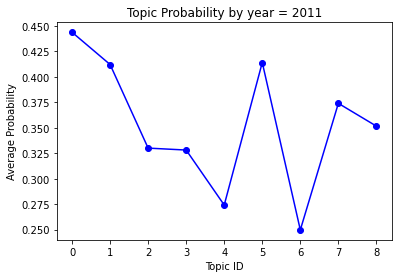

In [34]:
gene_plot_fyear(2011, tweets_by_year, lda_model)

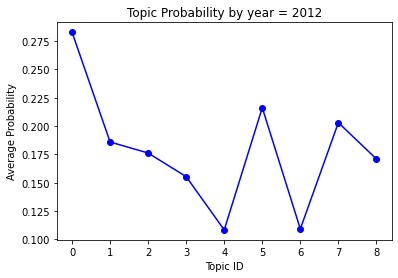

In [35]:
gene_plot_fyear(2012, tweets_by_year, lda_model)

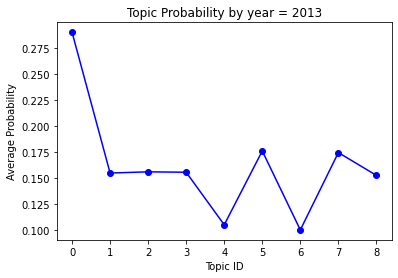

In [36]:
gene_plot_fyear(2013, tweets_by_year, lda_model)

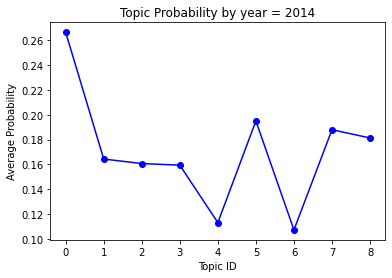

In [37]:
gene_plot_fyear(2014, tweets_by_year, lda_model)

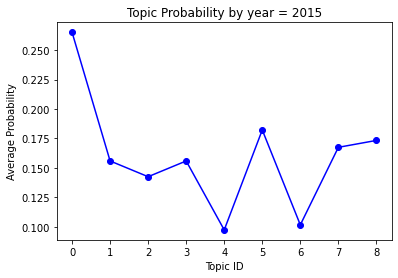

In [38]:
gene_plot_fyear(2015, tweets_by_year, lda_model)

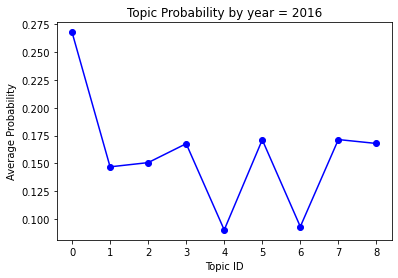

In [39]:
gene_plot_fyear(2016, tweets_by_year, lda_model)

## Network Analysis

### Network Construction

In [41]:
from itertools import combinations
from IPython.display import Image
import igraph as ig

In [35]:
def extract_user(tweet_dta, dupilcates_or_not=True):
    """
    Exract users from the tweet
    
    Inputs:
        tweet_dta: a pd.DataFrame
        dupilcates_or_not: a bool specifying whether to retain duplicates
    Outputs:
        user_lst: a list of lists of user names
    """
    
    user_lst = list()
    pattern = re.compile(r'@.+?[\s|:|：]')
    
    for tweet in tweet_dta.loc[:,'tweet']:
        users_unclean = re.findall(pattern, tweet)
        users = [user.strip() for user in users_unclean]
        users_clean = set([re.sub(r'@|:|：', '', user) for user in users])
        if len(users_clean) > 1:
            if dupilcates_or_not:
                user_lst.append(list(users_clean))
            else:
                user_lst.extend(list(users_clean))
    
    if dupilcates_or_not:
        return user_lst
    else:
        return list(set(user_lst))


def gene_edges(user_lst):
    """
    Generate edges among the users
    
    Inputs:
        user_lst: a list of lists of user names
    Outputs:
        edge_lst: a list of lists of tuples where each tuple corresponds to the edges
    """
    
    edge_lst = []
    
    for users in user_lst:
         edge_lst.extend(list(combinations(users,2)))
    
    return list(set(edge_lst))

    

In [36]:
# Construct the network
user_lst =  extract_user(tweet_dta, dupilcates_or_not=False)
edge_lst =  gene_edges(extract_user(tweet_dta, dupilcates_or_not=True))
network = ig.Graph(directed=False)
network.add_vertices(user_lst)
network.add_edges(edge_lst)

In [37]:
network.density()

0.001399760059787867

### Community Detection

In [38]:
cps = network.components()
cps.sizes()

# Extract the biggest component
g1 = cps.giant()

# uses the Spinglass community detection algorithm to find 
# communities (clusters of nodes) within the giant component of the graph
sgcom = g1.community_spinglass()
print(sgcom.summary())

Clustering with 2727 elements and 25 clusters


In [39]:
g1.vs['community'] = sgcom.membership
ncluster = max(g1.vs['community'])+1
c4c = ig.ClusterColoringPalette(ncluster)

for v in g1.vs:
    v['color'] = c4c.get(v['community'])

In [43]:
# Save the graph data
g1.save("data/g1.graphml")

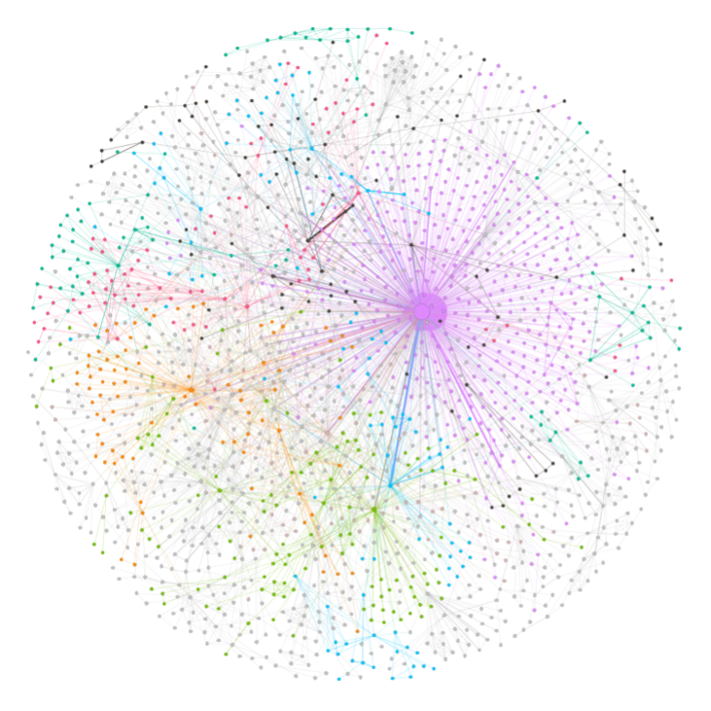

In [43]:
Image("data/g1.png")

In [42]:
# Showcase the Top 10 nodes ordered by degree
degree_list=[(node['name'],node.degree(),node.closeness()) for node in g1.vs if node.degree()>1]
degree_list.sort(key=lambda x:x[1],reverse=True)
network_df = pd.DataFrame(degree_list[:10:],columns=['Name','Degree','Closeness'])
network_df

,Name,Degree,Closeness
0,观察者网,1020,0.535560
1,今晚报,111,0.381259
2,四月网,105,0.384052
3,王小东,103,0.388043
4,吴法天,91,0.381739
5,点子正,85,0.380301
6,-逆光飞行-,81,0.376311
7,刘仰,76,0.380142
8,单车上的骑士,71,0.375069
9,蔡小心,67,0.375793
